In [1]:
!pip uninstall --yes h5py

Found existing installation: h5py 3.8.0
Uninstalling h5py-3.8.0:
  Successfully uninstalled h5py-3.8.0


In [2]:
# DEPENDENCIES ########################################################################################################################################


%pip install pandas
%pip install scikit_image
%pip install h5py


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
    --------------------------------------- 0.0/3.0 MB 991.0 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/3.0 MB 3.0 MB/s eta 0:00:01
   -------- ------------------------------- 0.7/3.0 MB 5.2 MB/s eta 0:00:01
   ------------------- -------------------- 1.4/3.0 MB 8.2 MB/s eta 0:00:01
   --------------------------- ------------ 2.1/3.0 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------  3.0/3.0 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 3.0/3.0 MB 10.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# IMPORTS #############################################################################################################################################

import numpy as np
import pandas as pd
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler

In [2]:
# PARAMETERS ##########################################################################################################################################


# Size of the images
img_height, img_width = 96,96

# Parameters
num_classes         = 7     # ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
epochs_top_layers   = 5
epochs_all_layers   = 100
batch_size          = 64

In [3]:
# DATASETS ############################################################################################################################################

# Folder where logs and models are stored
folder = 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/logs/RESNET50'

# Data paths
train_dataset	= 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/train'
eval_dataset 	= 'C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/validation'

In [4]:
# MODEL ###############################################################################################################################################

# Create the based on ResNet-50 architecture pre-trained model
    # model:        Selects one of the available architectures vgg16, resnet50 or senet50
    # include_top:  Whether to include the fully-connected layer at the top of the network
    # weights:      Pre-training on VGGFace
    # input_shape:  Optional shape tuple, only to be specified if include_top is False (otherwise the input
    #               shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with
    #               'channels_first' data format). It should have exactly 3 inputs channels, and width and
    #               height should be no smaller than 197. E.g. (200, 200, 3) would be one valid value.
# Returns a keras Model instance
base_model = ResNet50(
    include_top = False,
    weights     = 'imagenet',
    input_shape = (img_height, img_width, 3))

# Places x as the output of the pre-trained model
x = base_model.output

# Flattens the input. Does not affect the batch size
x = Flatten()(x)

# Add a fully-connected layer and a logistic layer
# Dense implements the operation: output = activation(dot(input, kernel) + bias(only applicable if use_bias is True))
    # units:        Positive integer, dimensionality of the output space
    # activation:   Activation function to use
    # input shape:  nD tensor with shape: (batch_size, ..., input_dim)
    # output shape: nD tensor with shape: (batch_size, ..., units)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# The model we will train
model = Model(inputs = base_model.input, outputs = predictions)
# model.summary()

In [5]:
# # DATA PREPARATION ####################################################################################################################################

#create an ImageDataGenerator and generate batches of data
def get_datagen(dataset, aug=False):
    if aug: #check if augmentation is enabled
        datagen = ImageDataGenerator(
                            rescale=1./255, #rescale the pixel values to [0,1]
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,  # Randomly rotate images by up to 10 degrees
                            width_shift_range=0.1, # Randomly shift images horizontally by up to 10% of the width
                            height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
                            zoom_range=0.1, # Randomly zoom into images by up to 10%
                            horizontal_flip=True) #randomly flip images horizontally
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(96, 96), 
            color_mode='rgb',
            shuffle = True, 
            class_mode='categorical',
            batch_size=batch_size) #size of the batch 

train_generator  = get_datagen(train_dataset, True)
dev_generator    = get_datagen(eval_dataset)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [6]:
# UPPER LAYERS TRAINING ###############################################################################################################################

# First: train only the top layers (which were randomly initialized) freezing all convolutional ResNet-50 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile (configures the model for training) the model (should be done *AFTER* setting layers to non-trainable)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       Float >= 0. Learning rate
        # beta_1:   Float, 0 < beta < 1. Generally close to 1
        # beta_2:   Float, 0 < beta < 1. Generally close to 1
        # epsilon:  Float >= 0. Fuzz factor
        # decay:    Float >= 0. Learning rate decay over each update
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08), 
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
# as well as activation histograms for the different layers in your model
    # log_dir:          The path of the directory where to save the log files to be parsed by TensorBoard
    # histogram_freq:   Frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
    #                   If set to 0, histograms won't be computed. Validation data (or split) must be specified for histogram visualizations
    # write_graph:      Whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True
    # write_grads:      Whether to visualize gradient histograms in TensorBoard. histogram_freq must be greater than 0
    # write_images:     Whether to write model weights to visualize as image in TensorBoard
# To visualize the files created during training, run in your terminal: tensorboard --logdir path_to_current_dir/Graph
tensorboard_top_layers = TensorBoard(
	log_dir         = folder + '/logs_top_layers',
	histogram_freq  = 0,
	write_graph     = True,
	write_images    = True)

# Train the model on the new data for a few epochs (Fits the model on data yielded batch-by-batch by a Python generator)
    # generator:        A generator or an instance of Sequence (keras.utils.Sequence) object in order to avoid duplicate data when using multiprocessing
    #                   The output of the generator must be either {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # steps_per_epoch:  Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch
    #                   It should typically be equal to the number of unique samples of your dataset divided by the batch size 
    # epochs:           Integer, total number of iterations on the data
    # validation_data:  This can be either {a generator for the validation data } {a tuple (inputs, targets)} {a tuple (inputs, targets, sample_weights)}
    # callbacks:        List of callbacks to be called during training (to visualize the files created during training, run in your terminal:
    #                   tensorboard --logdir path_to_current_dir/Graph)
model.fit(
    x           = train_generator,
    steps_per_epoch     = len(train_generator), # samples_per_epoch / batch_size
    epochs              = epochs_top_layers,                            
    validation_data     = dev_generator,
    callbacks           = [tensorboard_top_layers]
)

Epoch 1/5
449/449 [==============================] - 146s 312ms/step - loss: 1.8277 - accuracy: 0.2522 - val_loss: 1.7775 - val_accuracy: 0.2602
Epoch 2/5
449/449 [==============================] - 47s 104ms/step - loss: 1.7689 - accuracy: 0.2736 - val_loss: 1.7482 - val_accuracy: 0.3090
Epoch 3/5
449/449 [==============================] - 47s 105ms/step - loss: 1.7504 - accuracy: 0.2824 - val_loss: 1.7377 - val_accuracy: 0.3104
Epoch 4/5
449/449 [==============================] - 47s 105ms/step - loss: 1.7388 - accuracy: 0.2911 - val_loss: 1.6917 - val_accuracy: 0.3221
Epoch 5/5
449/449 [==============================] - 47s 105ms/step - loss: 1.7376 - accuracy: 0.2944 - val_loss: 1.7732 - val_accuracy: 0.2775


In [3]:
import tensorflow
print(tensorflow.__version__)

2.10.0


In [7]:
# FULL NETWORK TRAINING ###############################################################################################################################

# At this point, the top layers are well trained and we can start fine-tuning convolutional layers from ResNet-50


# Fine-tuning of all the layers
for layer in model.layers:
    layer.trainable = True

# We need to recompile the model for these modifications to take effect (we use SGD with nesterov momentum and a low learning rate)
    # optimizer:    String (name of optimizer) or optimizer object
        # lr:       float >= 0. Learning rate
        # momentum: float >= 0. Parameter updates momentum
        # decay:    float >= 0. Learning rate decay over each update
        # nesterov: boolean. Whether to apply Nesterov momentum
    # loss:     String (name of objective function) or objective function
    # metrics:  List of metrics to be evaluated by the model during training and testing
model.compile(
    optimizer   = SGD(learning_rate = 1e-4, momentum = 0.9, nesterov = True),
    loss        = 'categorical_crossentropy', 
    metrics     = ['accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
tensorboard_all_layers = TensorBoard(
    log_dir         = folder + '/logs_all_layers',
    histogram_freq  = 0,
    write_graph     = True,
    write_images    = True)

# Reduce learning rate when a metric has stopped improving
	# monitor: 	Quantity to be monitored
	# factor: 	Factor by which the learning rate will be reduced. new_lr = lr * factor
	# patience:	Number of epochs with no improvement after which learning rate will be reduced
	# mode: 	One of {auto, min, max}
	# min_lr:	Lower bound on the learning rate
reduce_lr_plateau = ReduceLROnPlateau(
	monitor 	= 'val_accuracy',
	factor		= 0.5,
	patience	= 3,
	mode 		= 'auto',
	min_lr		= 1e-8)

# Stop training when a monitored quantity has stopped improving
	# monitor:		Quantity to be monitored
	# patience:		Number of epochs with no improvement after which training will be stopped
	# mode: 		One of {auto, min, max}
early_stop = EarlyStopping(
	monitor 	= 'val_accuracy',
	patience 	= 10,
	mode 		= 'auto')
	

# Save the model after every epoch
	# filepath:       String, path to save the model file
	# monitor:        Quantity to monitor {val_loss, val_acc}
	# save_best_only: If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten
	# mode:           One of {auto, min, max}. If save_best_only = True, the decision to overwrite the current save file is made based on either
	#			      the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should
	#			      be min, etc. In auto mode, the direction is automatically inferred from the name of the monitored quantity
	# period:         Interval (number of epochs) between checkpoints

# We train our model again (this time fine-tuning all the resnet blocks)
model.fit(
    x           = train_generator,
    steps_per_epoch     = len(train_generator),  # samples_per_epoch / batch_size 
    epochs              = epochs_all_layers,                        
    validation_data     = dev_generator,
    callbacks           = [tensorboard_all_layers, reduce_lr_plateau,early_stop])

# SAVING ##############################################################################################################################################

# Saving the model in the workspace
model.save(folder + '/ResNet-50.h5')
# Save model.h5 on to google storage
with file_io.FileIO('ResNet-50.h5', mode='rb') as input_f:
    with file_io.FileIO(folder + '/ResNet-50.h5', mode='wb') as output_f:  # w+ : writing and reading
        output_f.write(input_f.read())

model.save('Inception-v3.h5')
with file_io.FileIO('Inception-v3.h5', mode='rb') as input_f:
    with file_io.FileIO(folder + '/Inception-v3.h5', mode='wb') as output_f:  # w+ : writing and reading
        output_f.write(input_f.read())

Epoch 1/100
449/449 [==============================] - 141s 303ms/step - loss: 2.0872 - accuracy: 0.3382 - val_loss: 6.7859 - val_accuracy: 0.1672 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - 135s 301ms/step - loss: 1.5143 - accuracy: 0.4394 - val_loss: 1.9284 - val_accuracy: 0.3483 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - 135s 301ms/step - loss: 1.3739 - accuracy: 0.4821 - val_loss: 1.4043 - val_accuracy: 0.4873 - lr: 1.0000e-04
Epoch 4/100
449/449 [==============================] - 135s 300ms/step - loss: 1.2937 - accuracy: 0.5129 - val_loss: 1.3205 - val_accuracy: 0.5038 - lr: 1.0000e-04
Epoch 5/100
449/449 [==============================] - 135s 300ms/step - loss: 1.2313 - accuracy: 0.5336 - val_loss: 1.2493 - val_accuracy: 0.5311 - lr: 1.0000e-04
Epoch 6/100
449/449 [==============================] - 135s 301ms/step - loss: 1.1849 - accuracy: 0.5568 - val_loss: 1.2172 - val_accuracy: 0.5475 - lr: 1.0000e-04
Epoch 7/100
449/

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe9 in position 71: invalid continuation byte

In [9]:
model.save(folder + '/ResNet-50.h5')
# # Save model.h5 on to google storage
# with file_io.FileIO('ResNet-50.h5', mode='rb') as input_f:
#     with file_io.FileIO(folder + '/ResNet-50.h5', mode='wb') as output_f:  # w+ : writing and reading
#         output_f.write(input_f.read())


In [10]:
test_dataset='C:/Users/skywalker/Desktop/Meriem_TAIEB_yasmine_MAHDOUI/facial_emotion_recognition/fer2013/test'
test_generator=get_datagen(test_dataset)

Found 7178 images belonging to 7 classes.


In [11]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(dev_generator)
print('dev loss, dev acc:', results_dev)

print('\n# Evaluate on test data')
results_test = model.evaluate(test_generator)
print('test loss, test acc:', results_test)

# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'dev'], loc='upper left')
# plt.show()


# Evaluate on dev data
57/57 [==============================] - 5s 88ms/step - loss: 1.0846 - accuracy: 0.6356
dev loss, dev acc: [1.0846110582351685, 0.6355530619621277]

# Evaluate on test data
113/113 [==============================] - 26s 228ms/step - loss: 1.0652 - accuracy: 0.6407
test loss, test acc: [1.0651787519454956, 0.6407077312469482]


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

113/113 [==============================] - 11s 90ms/step


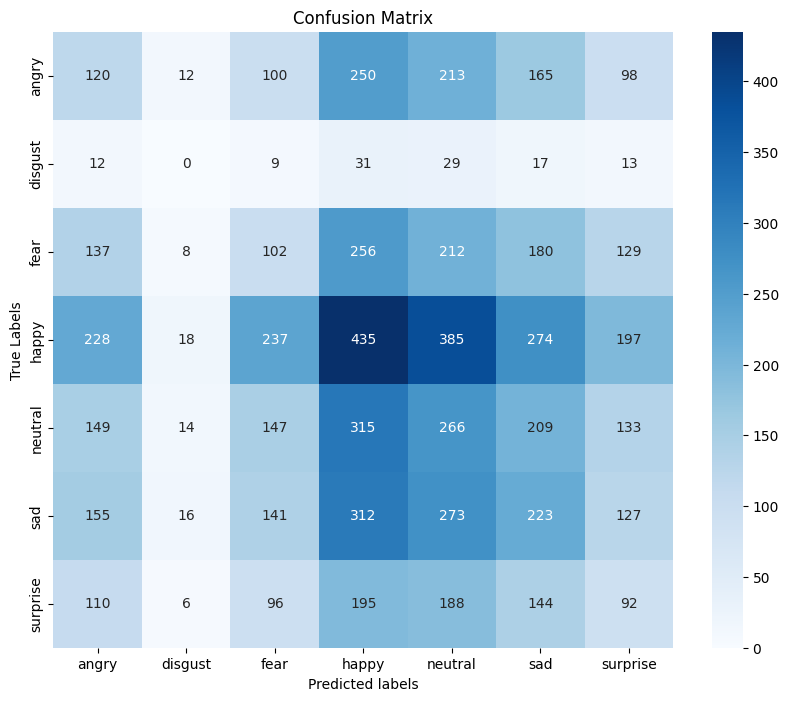

In [13]:
#get the true labels
true_labels=test_generator.classes
predicted_labels=model.predict(test_generator).argmax(axis=-1)

#confusion matrix
cm=confusion_matrix(true_labels,predicted_labels)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix")

plt.show()